In [1]:
import tensorflow as tf
import numpy as np
from time import time
from utils import plot_images, print_progress, read_mnist_data, add_variable_histogram_summaries, merge, interpolate
from os.path import exists
from glob import glob
import scipy

In [2]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


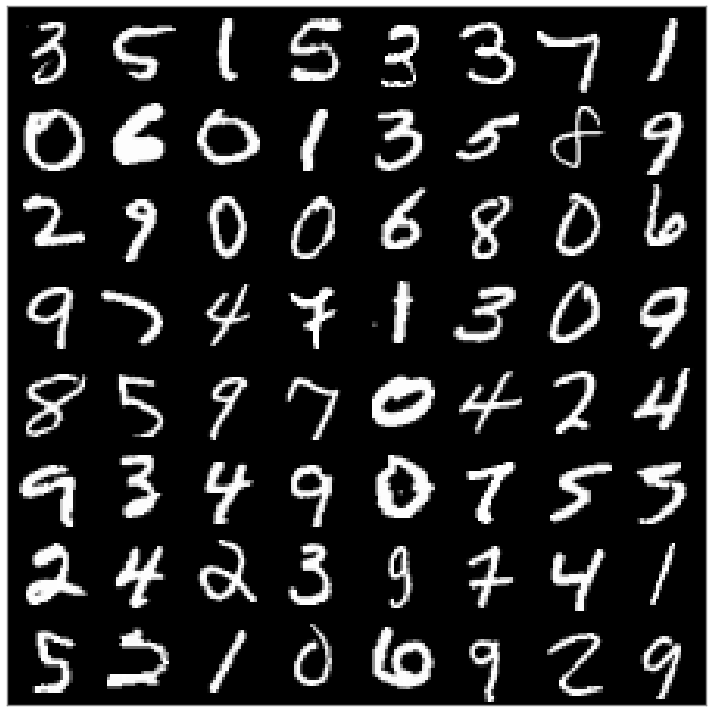

In [3]:
plot_images(merge(data.train.next_batch(64)[0]))

In [4]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

In [14]:
def generator(z, training):
    x_gen = tf.layers.dense(z, 7 * 7 * 256, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    x_gen = tf.reshape(x_gen, (-1, 7, 7, 256))
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn1')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 128, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv1')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn2')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 64, (5, 5), (2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv2')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn3')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 32, (5, 5), (1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv3')
    x_gen = tf.contrib.layers.batch_norm(x_gen, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn4')
    x_gen = tf.nn.relu(x_gen)
    
    x_gen = tf.layers.conv2d_transpose(x_gen, 1, (5, 5), (1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='tconv4')
    return tf.nn.tanh(x_gen)

In [15]:
def discriminator(img, training):
    p = tf.layers.conv2d(img, 32, (5, 5), strides=(1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv1')
    p = lrelu(p, 0.2, 'lrelu1')
    
    p = tf.layers.conv2d(p, 64, (5, 5), strides=(1, 1), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv2')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn1')
    p = lrelu(p, 0.2, 'lrelu2')
    
    p = tf.layers.conv2d(p, 128, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv3')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn2')
    p = lrelu(p, 0.2, 'lrelu3')
    
    p = tf.layers.conv2d(p, 256, (5, 5), strides=(2, 2), kernel_initializer=tf.random_normal_initializer(stddev=0.02), padding='same', name='conv4')
    p = tf.contrib.layers.batch_norm(p, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, is_training=training, scope='bn3')
    p = lrelu(p, 0.2, 'lrelu4')
    
    p = tf.reshape(p, (-1, 7 * 7 * 256))
    p = tf.layers.dense(p, 1, kernel_initializer=tf.random_normal_initializer(stddev=0.02), name='fc1')
    return p 

In [16]:
def predictor(z):
    score = tf.layers.dense(z, 1024, activation=tf.nn.relu, name='fc1')
    return tf.layers.dense(z, 1, name='fc2')

In [30]:
z_dim = 32

tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    training = tf.placeholder(tf.bool, name='training')
    x_image = tf.reshape(x, (-1, 28, 28, 1), 'x_image')
    
with tf.variable_scope('generator'):
    x_gen = generator(z, training) 
    
with tf.variable_scope('discriminator'):
    l_x = discriminator(x_image, training)
    tf.get_variable_scope().reuse_variables()
    l_g = discriminator(x_gen, training)
    
with tf.variable_scope('predictor'):
    l_p = predictor(z)
    
with tf.name_scope('optimizer'):
    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_g, labels=tf.ones_like(l_g)))
    loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_x, labels=tf.ones_like(l_x))) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_g, labels=tf.zeros_like(l_g)))
    loss_p = tf.reduce_mean((l_p - l_g) ** 2)
    optimizer_g = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_g = optimizer_g.compute_gradients(loss_g, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimize_g = optimizer_g.apply_gradients(grads_g)
    optimizer_d = tf.train.AdamOptimizer(2e-4, 0.5)
    grads_d = optimizer_d.compute_gradients(loss_d, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator'))
    optimize_d = optimizer_d.apply_gradients(grads_d)
    optimize_p = tf.train.AdamOptimizer(2e-4, 0.5).minimize(loss_p, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'predictor'))
    
tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
tf.summary.scalar('loss_p', loss_d)
add_variable_histogram_summaries()

for g_v_pair in grads_g:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])
        
for g_v_pair in grads_d:
    if not (g_v_pair[0] is None):
        tf.summary.histogram('grad-' + g_v_pair[1].name, g_v_pair[0])
        
summ = tf.summary.merge_all()

saver = tf.train.Saver()

INFO:tensorflow:Summary name generator/fc1/kernel:0 is illegal; using generator/fc1/kernel_0 instead.
INFO:tensorflow:Summary name generator/fc1/bias:0 is illegal; using generator/fc1/bias_0 instead.
INFO:tensorflow:Summary name generator/bn1/beta:0 is illegal; using generator/bn1/beta_0 instead.
INFO:tensorflow:Summary name generator/bn1/gamma:0 is illegal; using generator/bn1/gamma_0 instead.
INFO:tensorflow:Summary name generator/tconv1/kernel:0 is illegal; using generator/tconv1/kernel_0 instead.
INFO:tensorflow:Summary name generator/tconv1/bias:0 is illegal; using generator/tconv1/bias_0 instead.
INFO:tensorflow:Summary name generator/bn2/beta:0 is illegal; using generator/bn2/beta_0 instead.
INFO:tensorflow:Summary name generator/bn2/gamma:0 is illegal; using generator/bn2/gamma_0 instead.
INFO:tensorflow:Summary name generator/tconv2/kernel:0 is illegal; using generator/tconv2/kernel_0 instead.
INFO:tensorflow:Summary name generator/tconv2/bias:0 is illegal; using generator/tco

In [9]:
def plot_generated_images(sess, latent=None, save_name=None):
    if latent is None:
        latent = np.random.uniform(-1, 1, (11, z_dim))
        
    generated_images = merge((sess.run(x_gen, feed_dict={z: latent, training:False}) + 1) / 2)
    plot_images(generated_images)
    
    if save_name is not None:
        scipy.misc.imsave('output/MNIST/DCGAN-Predictive/' + save_name + '.jpg', generated_images[0])

In [22]:
batch_size = 64
plots_per_epoch = 3

batches_per_epoch = int(data.train.num_examples / batch_size)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def optimize(epochs=1):
    start_time = time()
    
    writer = tf.summary.FileWriter('checkpoints/DCGAN-Predictive', tf.get_default_graph())
    
    with tf.Session(config=config) as sess:
        if exists('checkpoints/DCGAN-Predictive/DCGAN-Predictive.data-00000-of-00001'):
            saver.restore(sess, 'checkpoints/DCGAN-Predictive/DCGAN-Predictive')
        else:
            sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            epoch_start_time = time()
            latent = np.random.uniform(-1, 1, (11, z_dim))
            for batch in range(batches_per_epoch):
                x_batch, _ = data.train.next_batch(batch_size)
                x_batch = x_batch / 0.5 - 1
                z_batch = np.random.uniform(-1, 1, (batch_size, z_dim))
                feed_dict_train = {x: x_batch, z: z_batch, training: True}
                for _ in range(1):
                    sess.run(optimize_d, feed_dict_train)
                for _ in range(2):
                    sess.run([optimize_g, optimize_p], feed_dict_train)

                if (epoch * batches_per_epoch + batch) % 100 == 0:
                    writer.add_summary(sess.run(summ, feed_dict_train), global_step=epoch * batches_per_epoch + batch)
                    
                if batch % int(np.ceil(batches_per_epoch / plots_per_epoch)) == 0:
                    plot_generated_images(sess, latent)
                    
                print_progress(batch, batches_per_epoch, epoch_start_time)
                
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_generated_images(sess)
            
            saver.save(sess, 'checkpoints/DCGAN-Predictive/DCGAN-Predictive', write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))
    writer.close()

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN-Predictive/DCGAN-Predictive


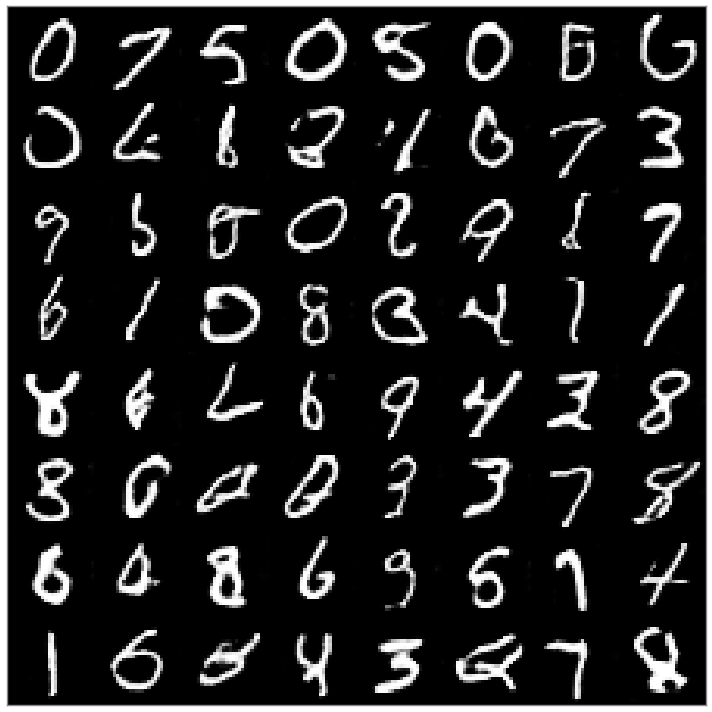

In [33]:
with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-Predictive/DCGAN-Predictive.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-Predictive/DCGAN-Predictive')
    else:
        sess.run(tf.global_variables_initializer())

    plot_generated_images(sess, np.random.uniform(-1, 1, (64, z_dim)))

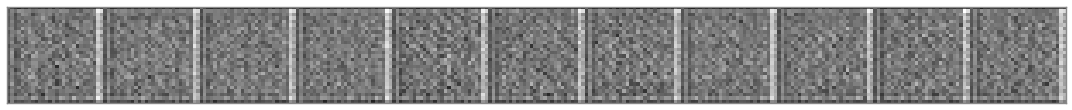

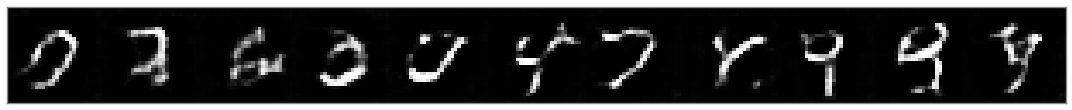

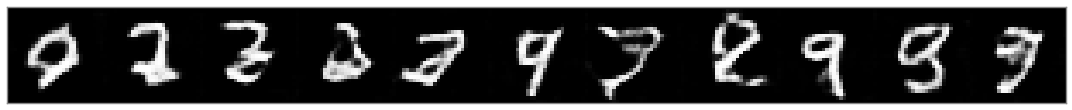

1 / 3 (33.33%)ted. Time - 85s, ETA - 0s


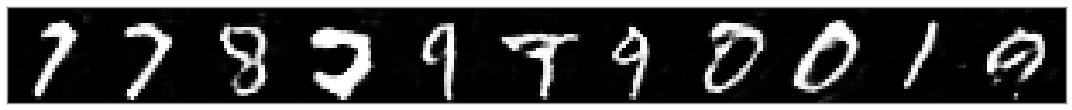

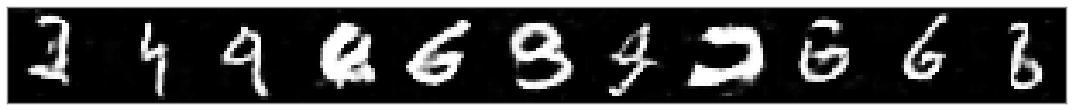

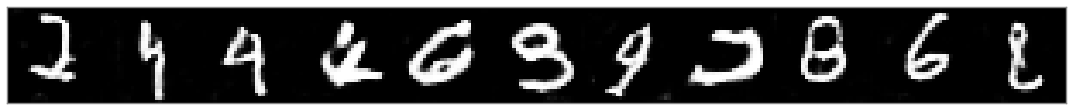

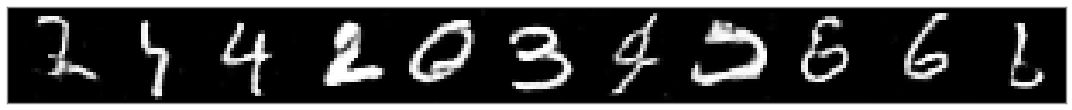

2 / 3 (66.67%)ted. Time - 88s, ETA - 0s


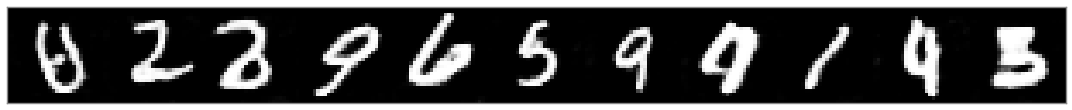

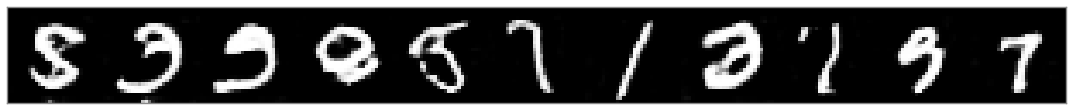

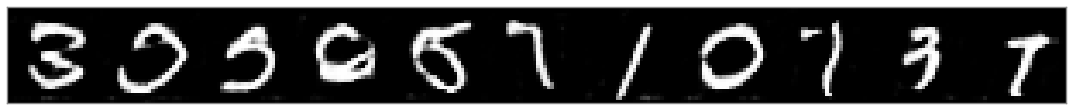

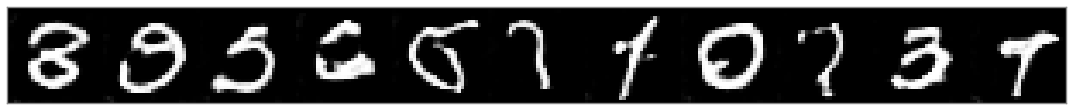

3 / 3 (100.0%)ted. Time - 87s, ETA - 0s


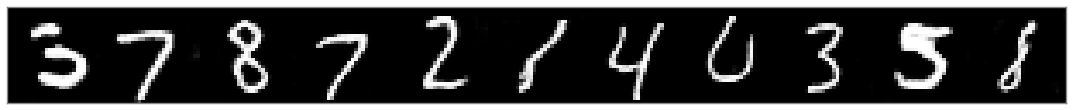

Time taken - 263.11s


In [32]:
optimize(3)

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN-Predictive/DCGAN-Predictive


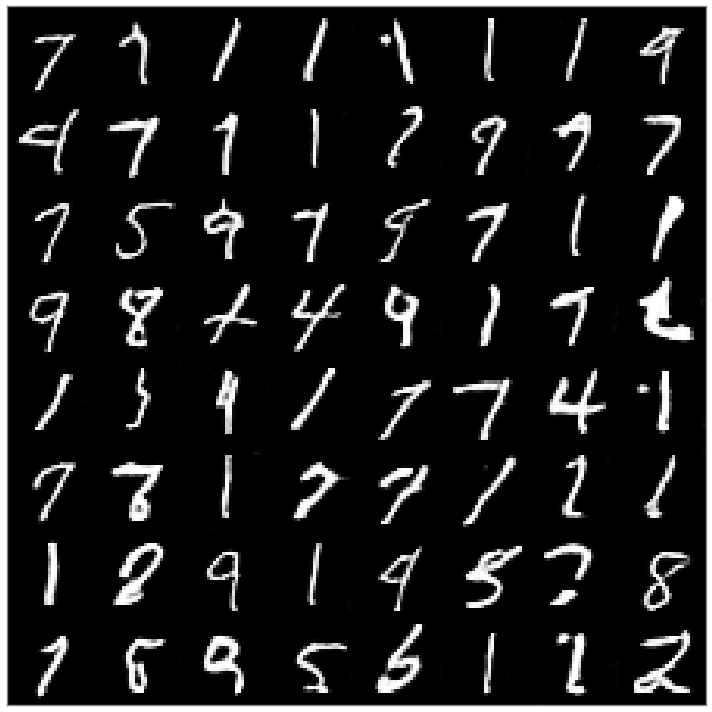

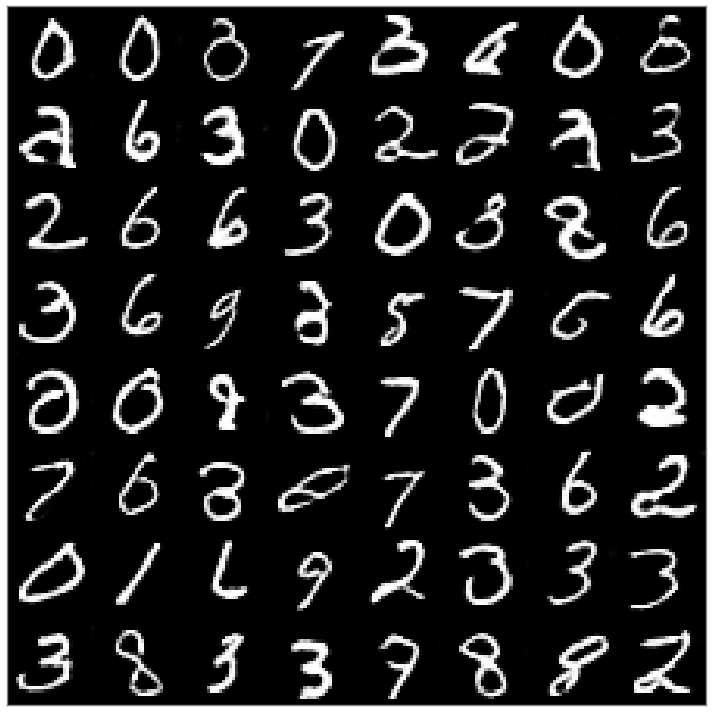

In [37]:
with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-Predictive/DCGAN-Predictive.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-Predictive/DCGAN-Predictive')
    else:
        sess.run(tf.global_variables_initializer())
        
    generated_images, predictor_prob, disc_prob = sess.run([x_gen, l_p, l_g], feed_dict={z: np.random.uniform(-1, 1, (640, z_dim)), training:False})
    best_idx = np.argsort(predictor_prob[:, 0])[::-1][:64]
    plot_images((merge(generated_images[best_idx]) + 1) / 2)
    best_idx = np.argsort(disc_prob[:, 0])[::-1][:64]
    plot_images((merge(generated_images[best_idx]) + 1) / 2)

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN/DCGAN


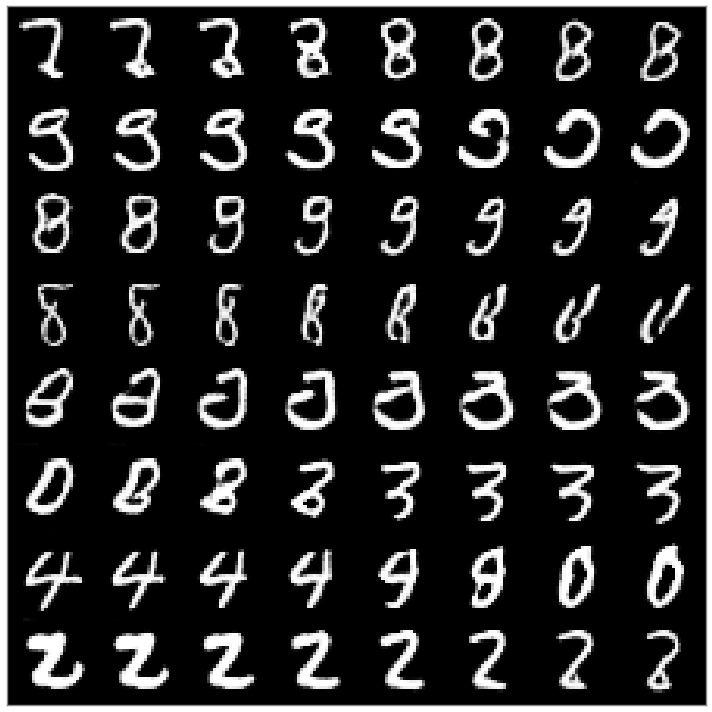

In [16]:
latent_points = []
for _ in range(8):
    latent_points += interpolate(np.random.uniform(-1, 1, (1, z_dim)), np.random.uniform(-1, 1, (1, z_dim)), 8)
    
with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-Predictive/DCGAN-Predictive.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-Predictive/DCGAN-Predictive')
    else:
        sess.run(tf.global_variables_initializer())
    
    plot_generated_images(sess, np.vstack(latent_points))

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN/DCGAN


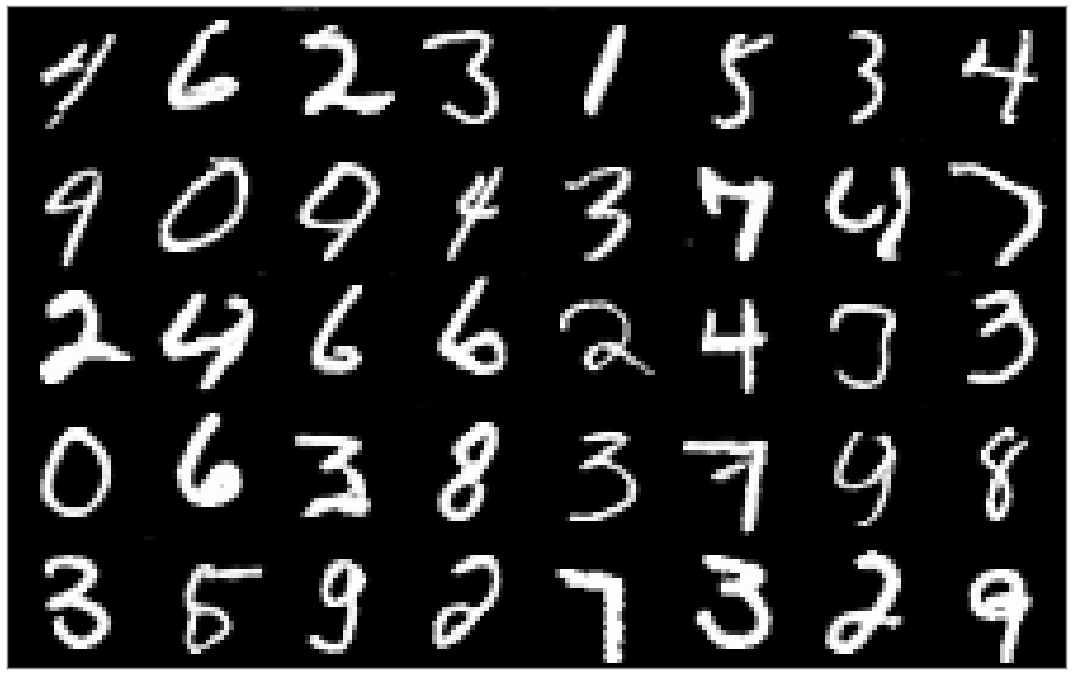

In [14]:
# Turing test
num_points = 40
frac_real = np.random.rand()

num_real = int(frac_real * num_points)
num_fake = num_points - num_real

def print_score(answers, real_answer_list):
    num_real = real_answer_list.count('r')
    num_fake = real_answer_list.count('f')
    num_points = num_real + num_fake
    if len(answers) != num_points:
        print("Answer length needs to be {}. Given {}.".format(num_points, len(answers)))
        return
    
    real_answer_list = list(joint_label[random_mix].flat)
    scores = np.zeros((num_points))
    errors = num_fake
    titles = [''] * num_points
    for i, answer in enumerate(answers):
        if answer == real_answer_list[i]:
            scores[i] = 1
            if answer == 'f':
                errors -= 1
            titles[i] = answer
        elif answer == 'f':
            titles[i] = "Blunder"
        else:
            titles[i] = "Forgery"

    plot_images(joint_data[random_mix], np.asarray(titles))
    print("Score: {}%\nError rate: {}%".format(int(scores.mean() * 100), int(errors / num_fake * 100)))
    
with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-Predictive/DCGAN-Predictive.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-Predictive/DCGAN-Predictive')
    else:
        sess.run(tf.global_variables_initializer())
        
    real_idx = np.load('data/MNIST/DCGAN-Predictive-Turing-real_idx.npy')
    #real_idx = np.random.randint(0, data.test.num_examples, num_real)
    #np.save('data/MNIST/DCGAN-Turing-real_idx.npy', real_idx)
    num_real = len(real_idx)
    real_data = data.test.images[real_idx].reshape(-1, 28, 28, 1)
    real_label = np.asarray(['r'] * num_real)
    latent = np.load('data/MNIST/DCGAN-Predictive-Turing-latent.npy')
    #latent = np.random.uniform(-1, 1, (num_fake * 100, z_dim))
    #np.save('data/MNIST/DCGAN-Turing-latent.npy', latent)
    num_fake = len(latent)
        
    fake_data, disc_prob = sess.run([x_gen, tf.nn.sigmoid(l_g)], feed_dict={z: latent, training:False})
    fake_label = np.asarray(['f'] * num_fake)
    joint_data = np.vstack([real_data, (fake_data + 1) / 2])
    joint_label = np.hstack([real_label, fake_label])
    
    random_mix = np.load('data/MNIST/DCGAN-Predictive-Turing-random_mix.npy')
    #random_mix = np.random.permutation(range(num_points))
    #np.save('data/MNIST/DCGAN-Turing-random_mix.npy', random_mix)
    plot_images(merge(joint_data[random_mix]))
    scipy.misc.imsave('data/MNIST/DCGAN-Predictive-Turing.jpg', merge(joint_data[random_mix])[0, :, :, 0])

In [15]:
my_answers = 'rffrfrrrrrrrrfffffrrrfrrrfrrrfrrrrrrffff'

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN/DCGAN

You human:


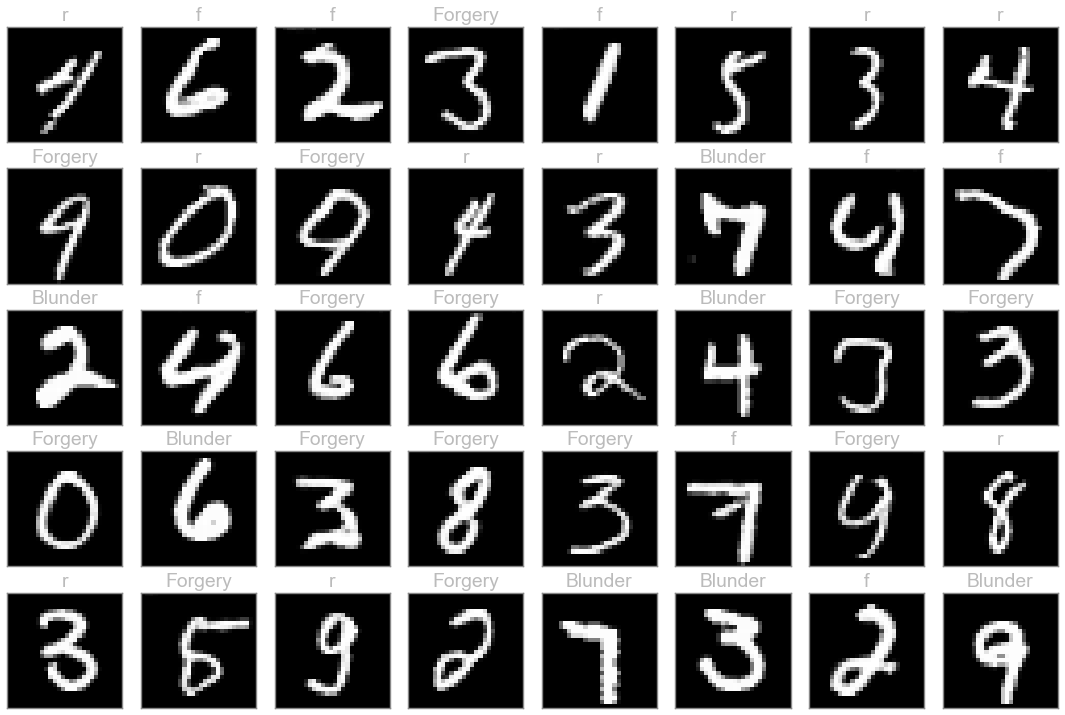

Score: 47%
Error rate: 63%

Discriminator:


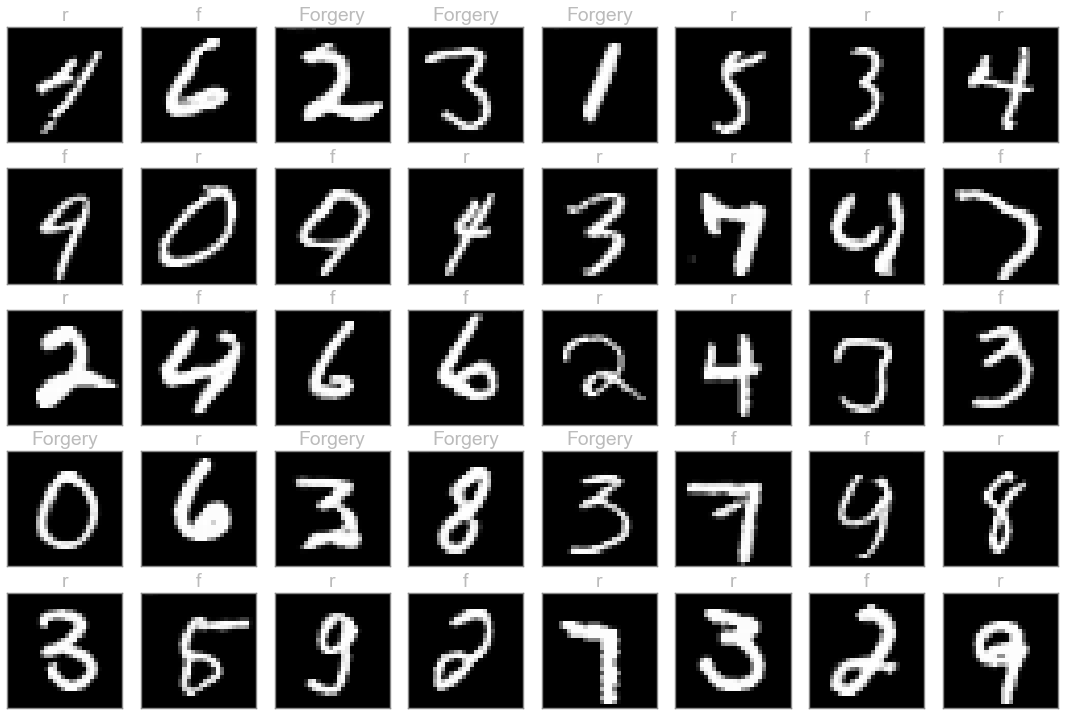

Score: 82%
Error rate: 31%


In [16]:
discriminator_answers = ''
with tf.Session(config=config) as sess:
    if exists('checkpoints/DCGAN-Predictive/DCGAN-Predictive.data-00000-of-00001'):
        saver.restore(sess, 'checkpoints/DCGAN-Predictive/DCGAN-Predictive')
    else:
        sess.run(tf.global_variables_initializer())
        
    real_probs, fake_probs = sess.run([tf.nn.sigmoid(l_x), tf.nn.sigmoid(l_g)], {x_image: real_data, x_gen: fake_data, training:False})
    joint_probs = np.vstack([real_probs, fake_probs])
    
    for prob in joint_probs[random_mix]:
        if prob >= 0.5:
            discriminator_answers += 'r'
        else:
            discriminator_answers += 'f'

print("\nYou human:")
print_score(my_answers, list(joint_label[random_mix]))
print("\nDiscriminator:")
print_score(discriminator_answers, list(joint_label[random_mix]))